/var/folders/8_/lltwgz4x48ncx3q3k86fr_tm0000gq/T/ipykernel_33390/3379001039.py:35: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(MODEL_PATH, map_loca

Plotting complete. Check the output directory for results.


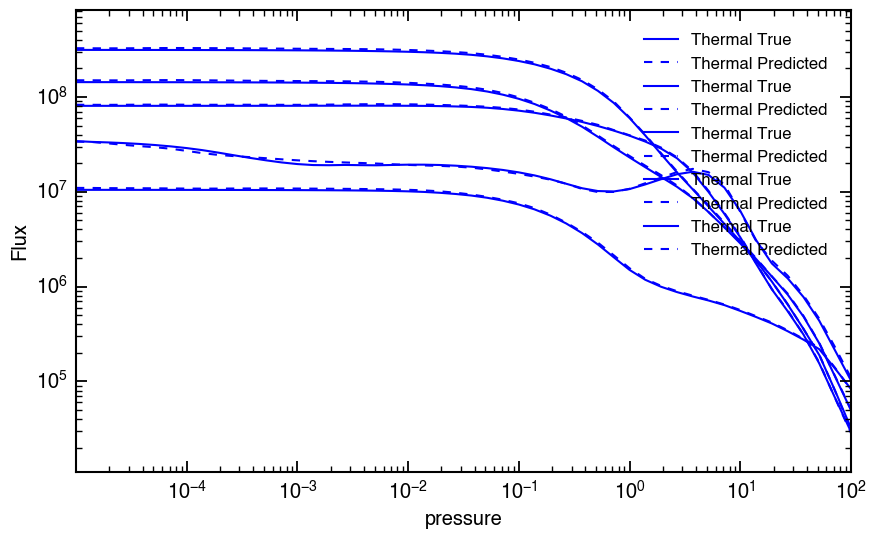

In [1]:
#!/usr/bin/env python3
"""
Simple script to plot thermal_net_flux and reflected_net_flux vs pressure on the same axis.
"""

import sys
import json
import glob
from pathlib import Path

import torch
import numpy as np
import matplotlib.pyplot as plt

plt.style.use('science.mplstyle')

# Add parent directory's src folder to the path for imports
BASE_DIR = Path.cwd()
SRC_DIR = BASE_DIR.parent / "src"
sys.path.append(str(SRC_DIR))

from normalizer import DataNormalizer

# Configuration - EDIT THESE PATHS as needed
MODEL_PATH = "../data/model/final_model.pt"
TEST_DATA_PATH = "../data/normalized_profiles"
NORM_METADATA_PATH = "../data/normalized_profiles/normalization_metadata.json"
OUTPUT_DIR = "../figures/"
MAX_SAMPLES = 5

# Create output directory if it doesn't exist
Path(OUTPUT_DIR).mkdir(parents=True, exist_ok=True)

# Load model checkpoint and configuration
checkpoint = torch.load(MODEL_PATH, map_location='cpu')
config = checkpoint['config']
model_state = checkpoint['state_dict']

# Get variable names from config
input_vars = config['input_variables']
target_vars = config['target_variables']
coord_vars_list = config.get('coordinate_variable', [])
if isinstance(coord_vars_list, list) and len(coord_vars_list) > 0:
    coord_var = coord_vars_list[0]
else:
    coord_var = None

# We force plotting for "thermal_net_flux" and "reflected_net_flux" vs "pressure"
thermal_feature = "thermal_net_flux"
reflected_feature = "reflected_net_flux"
plot_coord_var = "pressure"
if coord_var != "pressure":
    print("Warning: the coordinate variable in the config is not 'pressure'. Using:", coord_var)

# Import model architecture from src
from model import create_prediction_model

# Create and load model
model = create_prediction_model(config)
model.load_state_dict(model_state)
model.eval()

# Load normalization metadata
with open(NORM_METADATA_PATH, 'r') as f:
    metadata = json.load(f)

# Find test files (excluding the normalization metadata file)
json_files = [f for f in glob.glob(f"{TEST_DATA_PATH}/*.json")
              if Path(f).name != "normalization_metadata.json"][:MAX_SAMPLES]



plt.figure(figsize=(10, 6))
for file_path in json_files:
    filename = Path(file_path).stem

    # Load profile sample
    with open(file_path, 'r') as f:
        sample = json.load(f)

    # Extract coordinate values ("pressure") for plotting, if available
    if plot_coord_var in sample and isinstance(sample[plot_coord_var], list):
        coord_vals = sample[plot_coord_var]
        coord_denorm = DataNormalizer.denormalize(coord_vals, metadata, plot_coord_var)
    else:
        print(f"Warning: Coordinate variable '{plot_coord_var}' not found in sample {filename}. Using index values.")
        coord_denorm = list(range(100))  # fallback x-values

    # Determine expected sequence length from the configuration ("points" under pressure_range)
    expected_seq_len = config.get("pressure_range", {}).get("points", 100)

    # Prepare inputs with flexible padding/truncation for each input variable
    inputs = []
    for var in input_vars:
        if var in sample and isinstance(sample[var], list):
            values = sample[var]
            if len(values) < expected_seq_len:
                values = values + [0.0] * (expected_seq_len - len(values))
            elif len(values) > expected_seq_len:
                values = values[:expected_seq_len]
            inputs.append(torch.tensor(values, dtype=torch.float32))
        else:
            inputs.append(torch.zeros(expected_seq_len, dtype=torch.float32))

    # Stack inputs: shape (1, expected_seq_len, num_inputs)
    input_tensor = torch.stack(inputs, dim=1).unsqueeze(0)

    # Prepare coordinate tensor for model input (if used by the model)
    coords = None
    if plot_coord_var in sample and isinstance(sample[plot_coord_var], list):
        coord_input = sample[plot_coord_var]
        if len(coord_input) < expected_seq_len:
            coord_input = coord_input + [0.0] * (expected_seq_len - len(coord_input))
        elif len(coord_input) > expected_seq_len:
            coord_input = coord_input[:expected_seq_len]
        coords = torch.tensor(coord_input, dtype=torch.float32).unsqueeze(0)

    # Get predictions from the model
    with torch.no_grad():
        predictions = model(input_tensor, coords)

    # Ensure both target features are available in the sample
    missing = False
    for feature in [thermal_feature, reflected_feature]:
        if feature not in sample or not isinstance(sample[feature], list):
            print(f"Target feature '{feature}' not found in sample {filename}")
            missing = True
    if missing:
        continue

    # Get indices for the target features from the config
    try:
        thermal_idx = target_vars.index(thermal_feature)
    except ValueError:
        print(f"Target feature '{thermal_feature}' not in configuration for sample {filename}")
        continue

    try:
        reflected_idx = target_vars.index(reflected_feature)
    except ValueError:
        print(f"Target feature '{reflected_feature}' not in configuration for sample {filename}")
        continue

    # Retrieve true and predicted values for both features
    thermal_true_vals = sample[thermal_feature]
    thermal_pred_vals = predictions[0, :, thermal_idx].numpy().tolist()
    reflected_true_vals = sample[reflected_feature]
    reflected_pred_vals = predictions[0, :, reflected_idx].numpy().tolist()

    # Determine the minimum length among true values, predicted values, and coordinate values
    lengths = [
        len(thermal_true_vals), len(thermal_pred_vals),
        len(reflected_true_vals), len(reflected_pred_vals),
        len(coord_denorm)
    ]
    min_len = min(lengths)

    thermal_true_vals = thermal_true_vals[:min_len]
    thermal_pred_vals = thermal_pred_vals[:min_len]
    reflected_true_vals = reflected_true_vals[:min_len]
    reflected_pred_vals = reflected_pred_vals[:min_len]
    x_vals = coord_denorm[:min_len] if coord_denorm is not None else list(range(min_len))

    # Denormalize values using DataNormalizer
    thermal_true_denorm = DataNormalizer.denormalize(thermal_true_vals, metadata, thermal_feature)
    thermal_pred_denorm = DataNormalizer.denormalize(thermal_pred_vals, metadata, thermal_feature)
    reflected_true_denorm = DataNormalizer.denormalize(reflected_true_vals, metadata, reflected_feature)
    reflected_pred_denorm = DataNormalizer.denormalize(reflected_pred_vals, metadata, reflected_feature)

    # Create plot: plot both thermal and reflected flux vs pressure on the same axis
    plt.plot(x_vals, thermal_true_denorm, 'b-', label='Thermal True')
    plt.plot(x_vals, thermal_pred_denorm, 'b--', label='Thermal Predicted')

    #plt.plot(x_vals, reflected_true_denorm, 'g-', label='Reflected True')
    #plt.plot(x_vals, reflected_pred_denorm, 'g--', label='Reflected Predicted')
    plt.xlabel(plot_coord_var)
    plt.ylabel("Flux")
    plt.legend()
    plt.xscale('log')
    #plt.yscale('symlog')
    plt.yscale('log')


print("Plotting complete. Check the output directory for results.")


/var/folders/8_/lltwgz4x48ncx3q3k86fr_tm0000gq/T/ipykernel_33390/3896342002.py:35: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(MODEL_PATH, map_loca

Plotting complete. Check the output directory for results.


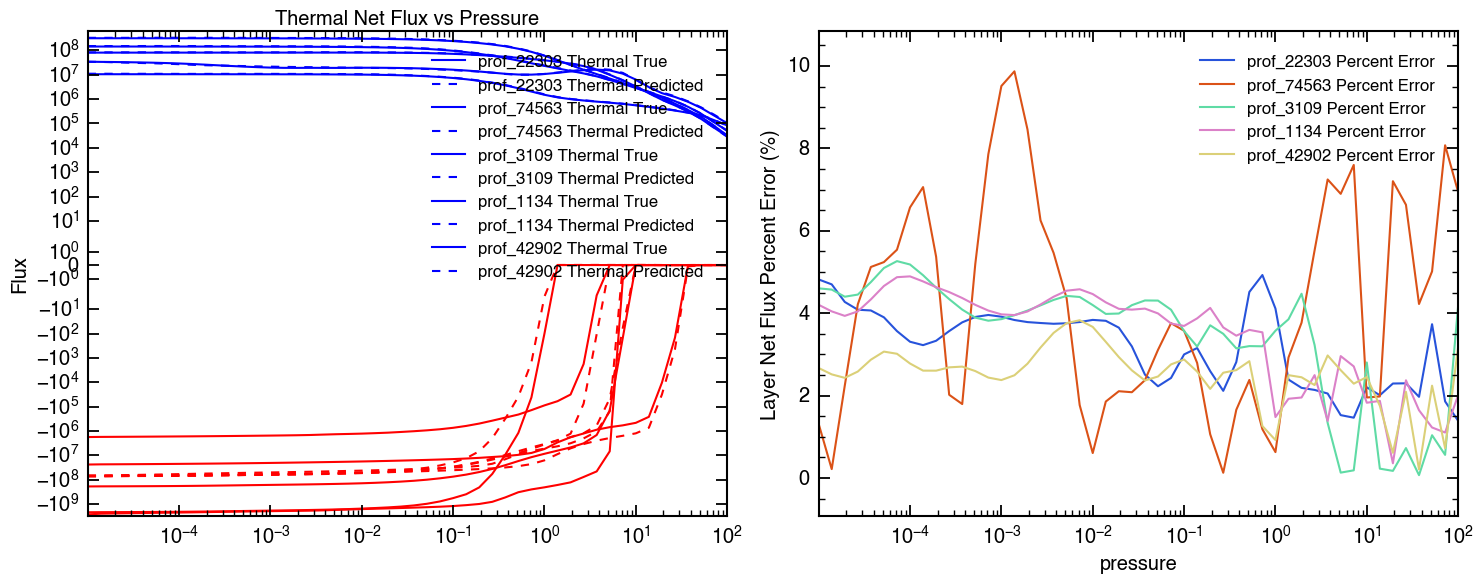

In [2]:
#!/usr/bin/env python3
"""
Simple script to plot thermal_net_flux vs pressure on the top panel and layer net flux percent error on the bottom panel.
"""

import sys
import json
import glob
from pathlib import Path

import torch
import numpy as np
import matplotlib.pyplot as plt

plt.style.use('science.mplstyle')

# Add parent directory's src folder to the path for imports
BASE_DIR = Path.cwd()
SRC_DIR = BASE_DIR.parent / "src"
sys.path.append(str(SRC_DIR))

from normalizer import DataNormalizer

# Configuration - EDIT THESE PATHS as needed
MODEL_PATH = "../data/model/final_model.pt"
TEST_DATA_PATH = "../data/normalized_profiles"
NORM_METADATA_PATH = "../data/normalized_profiles/normalization_metadata.json"
OUTPUT_DIR = "../figures/"
MAX_SAMPLES = 5

# Create output directory if it doesn't exist
Path(OUTPUT_DIR).mkdir(parents=True, exist_ok=True)

# Load model checkpoint and configuration
checkpoint = torch.load(MODEL_PATH, map_location='cpu')
config = checkpoint['config']
model_state = checkpoint['state_dict']

# Get variable names from config
input_vars = config['input_variables']
target_vars = config['target_variables']
coord_vars_list = config.get('coordinate_variable', [])
if isinstance(coord_vars_list, list) and len(coord_vars_list) > 0:
    coord_var = coord_vars_list[0]
else:
    coord_var = None

# We force plotting for "thermal_net_flux" and "reflected_net_flux" vs "pressure"
thermal_feature = "thermal_net_flux"
reflected_feature = "reflected_net_flux"
plot_coord_var = "pressure"
if coord_var != "pressure":
    print("Warning: the coordinate variable in the config is not 'pressure'. Using:", coord_var)

# Import model architecture from src
from model import create_prediction_model

# Create and load model
model = create_prediction_model(config)
model.load_state_dict(model_state)
model.eval()

# Load normalization metadata
with open(NORM_METADATA_PATH, 'r') as f:
    metadata = json.load(f)

# Find test files (excluding the normalization metadata file)
json_files = [f for f in glob.glob(f"{TEST_DATA_PATH}/*.json")
              if Path(f).name != "normalization_metadata.json"][:MAX_SAMPLES]







# Create a figure with two subplots (vertical panels)
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(15, 6), sharex=True)

for file_path in json_files:
    filename = Path(file_path).stem

    # Load profile sample
    with open(file_path, 'r') as f:
        sample = json.load(f)

    # Extract coordinate values ("pressure") for plotting, if available
    if plot_coord_var in sample and isinstance(sample[plot_coord_var], list):
        coord_vals = sample[plot_coord_var]
        coord_denorm = DataNormalizer.denormalize(coord_vals, metadata, plot_coord_var)
    else:
        print(f"Warning: Coordinate variable '{plot_coord_var}' not found in sample {filename}. Using index values.")
        coord_denorm = list(range(100))  # fallback x-values

    # Determine expected sequence length from the configuration ("points" under pressure_range)
    expected_seq_len = config.get("pressure_range", {}).get("points", 100)

    # Prepare inputs with flexible padding/truncation for each input variable
    inputs = []
    for var in input_vars:
        if var in sample and isinstance(sample[var], list):
            values = sample[var]
            if len(values) < expected_seq_len:
                values = values + [0.0] * (expected_seq_len - len(values))
            elif len(values) > expected_seq_len:
                values = values[:expected_seq_len]
            inputs.append(torch.tensor(values, dtype=torch.float32))
        else:
            inputs.append(torch.zeros(expected_seq_len, dtype=torch.float32))

    # Stack inputs: shape (1, expected_seq_len, num_inputs)
    input_tensor = torch.stack(inputs, dim=1).unsqueeze(0)

    # Prepare coordinate tensor for model input (if used by the model)
    coords = None
    if plot_coord_var in sample and isinstance(sample[plot_coord_var], list):
        coord_input = sample[plot_coord_var]
        if len(coord_input) < expected_seq_len:
            coord_input = coord_input + [0.0] * (expected_seq_len - len(coord_input))
        elif len(coord_input) > expected_seq_len:
            coord_input = coord_input[:expected_seq_len]
        coords = torch.tensor(coord_input, dtype=torch.float32).unsqueeze(0)

    # Get predictions from the model
    with torch.no_grad():
        predictions = model(input_tensor, coords)

    # Ensure both target features are available in the sample
    missing = False
    for feature in [thermal_feature, reflected_feature]:
        if feature not in sample or not isinstance(sample[feature], list):
            print(f"Target feature '{feature}' not found in sample {filename}")
            missing = True
    if missing:
        continue

    # Get indices for the target features from the config
    try:
        thermal_idx = target_vars.index(thermal_feature)
    except ValueError:
        print(f"Target feature '{thermal_feature}' not in configuration for sample {filename}")
        continue

    try:
        reflected_idx = target_vars.index(reflected_feature)
    except ValueError:
        print(f"Target feature '{reflected_feature}' not in configuration for sample {filename}")
        continue

    # Retrieve true and predicted values for both features
    thermal_true_vals = sample[thermal_feature]
    thermal_pred_vals = predictions[0, :, thermal_idx].numpy().tolist()
    reflected_true_vals = sample[reflected_feature]
    reflected_pred_vals = predictions[0, :, reflected_idx].numpy().tolist()

    # Determine the minimum length among true values, predicted values, and coordinate values
    lengths = [
        len(thermal_true_vals), len(thermal_pred_vals),
        len(reflected_true_vals), len(reflected_pred_vals),
        len(coord_denorm)
    ]
    min_len = min(lengths)

    thermal_true_vals = thermal_true_vals[:min_len]
    thermal_pred_vals = thermal_pred_vals[:min_len]
    reflected_true_vals = reflected_true_vals[:min_len]
    reflected_pred_vals = reflected_pred_vals[:min_len]
    x_vals = coord_denorm[:min_len] if coord_denorm is not None else list(range(min_len))

    # Denormalize values using DataNormalizer
    thermal_true_denorm = np.asarray(DataNormalizer.denormalize(thermal_true_vals, metadata, thermal_feature))
    thermal_pred_denorm = np.asarray(DataNormalizer.denormalize(thermal_pred_vals, metadata, thermal_feature))

    reflected_true_denorm = np.asarray(DataNormalizer.denormalize(reflected_true_vals, metadata, reflected_feature))
    reflected_pred_denorm = np.asarray(DataNormalizer.denormalize(reflected_pred_vals, metadata, reflected_feature))

    # Top panel: Plot thermal net flux (true and predicted) vs pressure
    ax1.plot(x_vals, thermal_true_denorm, 'b-', label=f'{filename} Thermal True')
    ax1.plot(x_vals, thermal_pred_denorm, 'b--', label=f'{filename} Thermal Predicted')

    ax1.plot(x_vals, reflected_true_denorm, 'r-')
    ax1.plot(x_vals, reflected_pred_denorm, 'r--')


    percent_error = np.abs((thermal_true_denorm - thermal_pred_denorm)) / thermal_true_denorm * 100


    # Bottom panel: Plot the layer net flux percent error vs pressure
    ax2.plot(x_vals, percent_error, label=f'{filename} Percent Error')

# Format top panel
ax1.set_ylabel("Flux")
ax1.set_xscale('log')
ax1.set_yscale('symlog')
ax1.legend()
ax1.set_title("Thermal Net Flux vs Pressure")

# Format bottom panel
ax2.set_xlabel(plot_coord_var)
ax2.set_ylabel("Layer Net Flux Percent Error (%)")
ax2.legend()
ax2.set_xscale('log')

plt.tight_layout()
plt.savefig(f"{OUTPUT_DIR}/flux_plots.png")
print("Plotting complete. Check the output directory for results.")
